## Make dataset - Reasoning Case

In [1]:
import os 
import pandas as pd 

data_dir = os.listdir('./gsm') 
#gsm_base_train = []
gsm_prefix_train = []

# /mnt/home/chaeyun-jang/reasoning_calibration/gsm/gsm_prefix_new_out_zs_train_0.csv

for p in data_dir:
    if "prefix_new_out" in p:
        gsm_prefix_train.append(pd.read_csv(os.path.join('./gsm',p)))
    #if "base" in p:
    #    gsm_base_train.append(pd.read_csv(os.path.join('./gsm',p)))
    #elif "prefix" in p:
    #    gsm_prefix_train.append(pd.read_csv(os.path.join('./gsm',p)))

In [2]:
#print(len(gsm_base_train))
#print(len(gsm_prefix_train))
print(len(gsm_prefix_train))

11


In [3]:
import re 

def extract_hash_answer(text: str):
    if "####" not in text:
        return None
    return text.split("####")[1].strip()

def extract_parsed_answer(text: str):
    try: 
        return re.sub(r'[^0-9.]', '', text.split("**Model\'s Final Answer is:**")[-1].split('\n')[0].strip())
    except:
        return ''

In [4]:
import re 

true_answer = [re.sub(r'[^0-9.]', '', extract_hash_answer(t)) for t in gsm_prefix_train[0]['true_answer']]

In [5]:
def make_train_data(main_df, data_list, true_answer):
    conf_labels = []
    for i in range(len(main_df)):
        temp_tf = []
        for data in data_list[1:]:
            temp_tf.append(extract_parsed_answer(data['parsed_answer'][i]) == true_answer[i])
        conf_labels.append(int(sum(temp_tf)/len(temp_tf)*100))
    main_df['conf_labels'] = conf_labels
    main_df.drop(columns=['parsed_answer'], inplace=True)
    return main_df

In [6]:
#new_base = make_train_data(gsm_base_train[0], gsm_base_train, true_answer)
new_base = make_train_data(gsm_prefix_train[0], gsm_prefix_train, true_answer)

In [7]:
print(new_base['question'][0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 04 May 2025

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

This is a conversation between **User** and **Assistant**.
The User asks a question, and the Assistant provides a thoughtful, reasoned answer.

The Assistant first reasons step‑by‑step to find the answer. This reasoning is enclosed in <think> ... </think> tags.
Next, the Assistant reflects on **its own confidence** in that reasoning, enclosed in <confidence_think> ... </confidence_think> tags.
Then, a final answer is provided in <answer> ... </answer> tags.
Finally, the Assistant outputs a scalar confidence score in <confidence> ... </confidence> tags, representing certainty on a scale from 0 to 100.

**Example:**
{question}
<think>{reasoning to solve the problem}</think>
<confidence_think>{reasoning about confidence}</confidence_think>
<answer>{final answer}</answer>
<confidence>{conf

In [8]:
print(new_base['pred_answer'][0])

{question}
<think>Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. To find the total number of clips sold, we need to add the number of clips sold in April and May. Since she sold half as many clips in May, we can calculate the number of clips sold in May by dividing the number of clips sold in April by 2. So, the number of clips sold in May is 48 / 2 = 24. Now, we can add the number of clips sold in April and May to find the total number of clips sold. The total number of clips sold is 48 + 24 = 72.</think>
<confidence_think>I am 100% confident in my reasoning because I have followed a logical and step-by-step approach to solve the problem. I have clearly defined the problem, identified the information given, and used a simple mathematical operation to find the solution.</confidence_think>
<answer>72</answer>
<confidence>100</confidence>


In [9]:
base_input_prompt = [new_base['question'][i] for i in range(len(new_base))]
base_answer_label = [new_base['pred_answer'][i].rsplit("</think>", 1)[0] + "</think>" for i in range(len(new_base))]
base_conf_input_prompt = [new_base['question'][i] + new_base['pred_answer'][i].rsplit("<confidence>", 1)[0] for i in range(len(new_base))]
base_conf_label = [f"<confidence>{new_base['conf_labels'][i]}</confidence>" for i in range(len(new_base))]

new_base['input_prompt'] = base_input_prompt    
new_base['answer_label'] = base_answer_label
new_base['confidence_input_prompt'] = base_conf_input_prompt
new_base['confidence_label'] = base_conf_label

In [10]:
print(new_base['input_prompt'][0])
print("========================")
print(new_base['answer_label'][0])
print("========================")
print(new_base['confidence_input_prompt'][0])
print("========================")
print(new_base['confidence_label'][0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 04 May 2025

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

This is a conversation between **User** and **Assistant**.
The User asks a question, and the Assistant provides a thoughtful, reasoned answer.

The Assistant first reasons step‑by‑step to find the answer. This reasoning is enclosed in <think> ... </think> tags.
Next, the Assistant reflects on **its own confidence** in that reasoning, enclosed in <confidence_think> ... </confidence_think> tags.
Then, a final answer is provided in <answer> ... </answer> tags.
Finally, the Assistant outputs a scalar confidence score in <confidence> ... </confidence> tags, representing certainty on a scale from 0 to 100.

**Example:**
{question}
<think>{reasoning to solve the problem}</think>
<confidence_think>{reasoning about confidence}</confidence_think>
<answer>{final answer}</answer>
<confidence>{conf

In [18]:
from transformers import set_seed

set_seed(0)

train_df = new_base.sample(frac=0.9, random_state=1)
val_df = new_base.drop(train_df.index)

train_df.to_csv('./data/processed/prefix_out_new/train.csv', index=False)
val_df.to_csv('./data/processed/prefix_out_new/valid.csv', index=False)

/mnt/home/chaeyun-jang/.conda/envs/llm_ft/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Make suffix dataset

In [1]:
import pandas as pd 

train_data = pd.read_csv("./data/processed/base/cot_kl/train.csv")
valid_data = pd.read_csv("./data/processed/base/cot_kl/valid.csv")

In [2]:
print(train_data['answer_label'][0])

{question}
<think>First, we need to find out how many koalas Legoland has. Since there are 5 kangaroos for each koala, we can divide the total number of kangaroos by 5 to find the number of koalas.</think>
<think>So, we divide 180 kangaroos by 5 to find the number of koalas: 180 ÷ 5 = 36.</think>
<think>Now that we know Legoland has 36 koalas, we can add this to the number of kangaroos to find the total number of animals.</think>
<think>Adding the number of kangaroos (180) to the number of koalas (36) gives us the total number of animals: 180 + 36 = 216.</think>
<answer>There are 216 koalas and kangaroos altogether at Legoland.</answer>


In [7]:
print(train_data['confidence_input_prompt'][0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 17 Apr 2025

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

This is a conversation between **User** and **Assistant**.
The User asks a question, and the Assistant provides a solution.
Before answering, the Assistant reasons through the problem step-by-step.
The reasoning is enclosed within `<think> ... </think>`, and the final answer within `<answer> ... </answer>`.

Example:
{question}
<think>{step-by-step reasoning}</think>
<answer>{final answer}</answer>

Now, respond to the following using the **exact same format**:
Legoland has 5 kangaroos for each koala. If Legoland has 180 kangaroos, how many koalas and kangaroos are there altogether?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{question}
<think>First, we need to find out how many koalas Legoland has. Since there are 5 kangaroos for each koala, we can divide the total number 

In [9]:
print(train_data['confidence_label'][0])

<confidence>60</confidence>


In [3]:
from src.prompt_hub import SUFFIX_CONFIDENCE_OUT

suffix_prompt = SUFFIX_CONFIDENCE_OUT
print(suffix_prompt)


First, reflect on your certainty inside <confidence_think> ... </confidence_think> tags, then provide a single score from 0 to 100 inside <confidence> ... </confidence> tags. How confident are you in your previous answer? 


In [10]:
new_train_conf_prompt = [p.replace("\nPlease respond with a score from 0 to 100 in `<confidence> </confidence>` tags. How confident are you in your previous answer?", suffix_prompt) for p in train_data['confidence_input_prompt']]
new_valid_conf_prompt = [p.replace("\nPlease respond with a score from 0 to 100 in `<confidence> </confidence>` tags. How confident are you in your previous answer?", suffix_prompt) for p in valid_data['confidence_input_prompt']]

train_data['confidence_input_prompt'] = new_train_conf_prompt
valid_data['confidence_input_prompt'] = new_valid_conf_prompt

In [11]:
print(train_data['confidence_input_prompt'][0])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 17 Apr 2025

You are a helpful assistant.<|eot_id|><|start_header_id|>user<|end_header_id|>

This is a conversation between **User** and **Assistant**.
The User asks a question, and the Assistant provides a solution.
Before answering, the Assistant reasons through the problem step-by-step.
The reasoning is enclosed within `<think> ... </think>`, and the final answer within `<answer> ... </answer>`.

Example:
{question}
<think>{step-by-step reasoning}</think>
<answer>{final answer}</answer>

Now, respond to the following using the **exact same format**:
Legoland has 5 kangaroos for each koala. If Legoland has 180 kangaroos, how many koalas and kangaroos are there altogether?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{question}
<think>First, we need to find out how many koalas Legoland has. Since there are 5 kangaroos for each koala, we can divide the total number 

In [12]:
train_data.to_csv("/mnt/home/chaeyun-jang/reasoning_calibration/data/processed/base_out/train_pre.csv", index=False)
valid_data.to_csv("/mnt/home/chaeyun-jang/reasoning_calibration/data/processed/base_out/valid_pre.csv", index=False)

In [13]:
new_train_data = pd.read_csv("/mnt/home/chaeyun-jang/reasoning_calibration/logs/2025-05-10T20-51-08/base_zs/gsm0_train.csv")

In [14]:
new_train_data

,pred_answer
0,NaN
1,NaN
2,<confidence>90</confidence>
3,NaN
4,<confidence>90</confidence>
...,...
6721,NaN
6722,NaN
6723,NaN
6724,<confidence>90</confidence>


## Evaluation

In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.2-3B-Instruct')
model = AutoModelForCausalLM.from_pretrained('meta-llama/Llama-3.2-3B-Instruct', device_map="auto")

import pandas as pd 

/mnt/home/chaeyun-jang/.conda/envs/llm_ft/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.14s/it]


In [2]:
#data_0 = pd.read_csv("/mnt/home/chaeyun-jang/reasoning_calibration/logs/2025-04-30T15-18-08/base_evaluation/gsm_test.csv")
#data_0['pred_answer'] = [q+p for q, p in zip(data_0['pred_answer'], data_0['conf'])]
data = pd.read_csv("/mnt/home/chaeyun-jang/reasoning_calibration/logs/2025-05-10T18-47-31/base_evaluation/gsm_test.csv")

In [3]:
print(data['pred_answer'][0])

<question>
Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?
</question>

<think>
To find out how much Janet makes at the farmers' market, we need to first determine how many eggs she has left after eating and baking. 
She eats 3 eggs for breakfast and bakes 4 muffins, which means she uses 3 + 4 = 7 eggs. 
Since her ducks lay 16 eggs per day, the number of eggs left is 16 - 7 = 9 eggs.
</think>

<answer>
Janet makes $2 per egg, and she has 9 eggs left to sell. Therefore, she makes 9 * $2 = $18 every day at the farmers' market.


In [4]:
# sampling 0.5 of data_0 and 0.5 of data_1 and remove dulicates of columns ['question', 'true_answer']

def sample_and_remove_duplicates(df1, df2, sample_fraction=1.0):
    # Sample 50% of df1
    sampled_df1 = df1.sample(frac=sample_fraction, random_state=1)

    # Sample 50% of df2
    sampled_df2 = df2.sample(frac=sample_fraction, random_state=1)

    # Concatenate the two sampled DataFrames
    combined_df = pd.concat([sampled_df1, sampled_df2], ignore_index=True)

    # Remove duplicates based on the specified columns
    combined_df = combined_df.drop_duplicates(subset=['true_answer'])

    return combined_df
#data = sample_and_remove_duplicates(data_0, data_1, sample_fraction=0.9)

In [5]:

parsing_prompt  = """Instruction:
We have a user's question and a model's generated response:

Your task:
1. Carefully read the question and the generated response in **Example 6 only**.
2. Extract the final answer based on the following rules:
    - If the response contains a number (with or without units), **extract only the numeric value**.
    - If the response is purely textual (no numbers), **extract the exact string as it appears**.
3. Use the following output format:
    - **Model's Final Answer is:** [Your extracted answer]

Rules:
- Only process **Example 6** for extraction. Ignore all other examples.
- Do not include units, symbols, or extra text when extracting numbers.
- Provide the answer strictly in the requested format without additional explanations.

### Examples

#### Example 1:
- Model's Generated Response: It takes about 160 minutes.
- **Model's Final Answer is:** 160

#### Example 2:
- Model's Generated Response: The nearest star is approximately 4.24 light years away.
- **Model's Final Answer is:** 4.24

#### Example 3:
- Model's Generated Response: The tallest mountain is Mount Everest.
- **Model's Final Answer is:** Mount Everest

#### Example 4:
- Model's Generated Response: It weighs 5 kg.
- **Model's Final Answer is:** 5

#### Example 5:
- Model's Generated Response: 81 + 221 - 24 = 278.
- **Model's Final Answer is:** 278

#### Example 6:
- Model's Generated Response: {answer_text}"""

check_prompt = f"""Instruction:
You will be given two answers:

1. The model's predicted answer
2. The ground-truth answer

Your task is to determine whether these two answers are mathematically equivalent.

Rules:
- Only process **Example 5** for extraction. Ignore all other examples.
- Only output **"True"** if they are mathematically the same.
- Otherwise, output **"False"**.
- Consider that equivalent fractions (e.g., "0.5" and "\\frac{{1}}{{2}}") or numerically equal expressions (e.g., "3/4" and "0.75") should be treated as equal.
- Ignore differences in formatting, units, LaTeX syntax, or spacing.
- Do not include any explanation—just output the final answer.

### Examples

### Example 1:

Model's Answer: \\frac{{1}}{{4}}  
Ground-truth Answer: 0.25  
Answer: True

### Example 2:

Model's Answer: 5  
Ground-truth Answer: 6  
Answer: False

### Example 3:

Model's Answer: x = 2  
Ground-truth Answer: x = 2  
Answer: True

### Example 4:

Model's Answer: \\frac{{3}}{{5}}  
Ground-truth Answer: 0.6  
Answer: True

### Example 5:

Model's Answer: <model_answer>  
Ground-truth Answer: <ground_truth_answer>"""

In [6]:
def extract_hash_answer(text: str):
    if "####" not in text:
        return None
    return text.split("####")[1].strip()


def extract_xml_answer(text: str) -> str:
    answer = text.split("<answer>")[-1]
    answer = answer.split("</answer>")[0]
    return answer.strip()


def extract_number_xml_confidence(text: str) -> float:
    try:
        confidence = text.split("<confidence>")[-1]
        confidence = confidence.split("</confidence>")[0]
        import re; cleaned = re.sub(r'[^0-9.]', '', confidence)
        return float(cleaned)
    except:
        return -1

In [7]:
import re 

true_answer_text = [re.sub(r'[^0-9.]', '', extract_hash_answer(t)) for t in list(data['true_answer'])]
pred_answer_text = [extract_xml_answer(t) for t in list(data['pred_answer'])]

In [8]:
input_data = [parsing_prompt.replace("{answer_text}", t) for t in pred_answer_text]
#input_data = [
#    check_prompt.replace("<model_answer>", pred_answer_text[i]).replace("<ground_truth_answer>", true_answer_text[i])
#    for i in range(len(pred_answer_text))
#]
print(input_data[0])

Instruction:
We have a user's question and a model's generated response:

Your task:
1. Carefully read the question and the generated response in **Example 6 only**.
2. Extract the final answer based on the following rules:
    - If the response contains a number (with or without units), **extract only the numeric value**.
    - If the response is purely textual (no numbers), **extract the exact string as it appears**.
3. Use the following output format:
    - **Model's Final Answer is:** [Your extracted answer]

Rules:
- Only process **Example 6** for extraction. Ignore all other examples.
- Do not include units, symbols, or extra text when extracting numbers.
- Provide the answer strictly in the requested format without additional explanations.

### Examples

#### Example 1:
- Model's Generated Response: It takes about 160 minutes.
- **Model's Final Answer is:** 160

#### Example 2:
- Model's Generated Response: The nearest star is approximately 4.24 light years away.
- **Model's Fin

In [9]:
from tqdm import tqdm 

model.generation_config.pad_token_id = tokenizer.eos_token_id

all_data = []
for i in tqdm(range(len(input_data))):
    real_input = tokenizer.apply_chat_template(
        [{"role": "user", "content": input_data[i]}], 
        tokenize=False
    )
    input_ids = tokenizer(real_input, return_tensors="pt").to('cuda')
    output = model.generate(**input_ids, 
                            do_sample=False, 
                            temperature=1.0, 
                            top_p=1.0, 
                            max_new_tokens=20)
    decode = tokenizer.decode(output[0], skip_special_tokens=True)
    all_data.append(decode)

100%|██████████| 1319/1319 [10:21<00:00,  2.12it/s]


In [11]:
import re
true_answer_text = [re.sub(r'[^0-9.]', '', extract_hash_answer(t)) for t in list(data['true_answer'])]
new_all_data = [a.split('**Model\'s Final Answer is:**')[-1].split('\n')[0] for a in all_data]
newnew_all_data = []

for a in new_all_data:
    try:
        newnew_all_data.append(re.sub(r'[^0-9.]', '', a))
    except:
        newnew_all_data.append('')

tf = [1 if str(g) == str(p) else 0 for g, p in zip(true_answer_text, newnew_all_data)]
print(sum(tf) / len(tf))

0.643669446550417


In [14]:
data.head()

,question,pred_answer,true_answer,conf
0,This is a conversation between **User** and **...,<question>\nJanet’s ducks lay 16 eggs per day....,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...,<confidence>80</confidence>
1,This is a conversation between **User** and **...,<question>\nA robe takes 2 bolts of blue fiber...,It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...,<confidence>100</confidence>
2,This is a conversation between **User** and **...,{question}\n<think>\nTo find the profit Josh m...,The cost of the house and repairs came out to ...,<confidence>30</confidence>
3,This is a conversation between **User** and **...,"{question}\n<think>First, we need to calculate...",He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...,<confidence>80</confidence>
4,This is a conversation between **User** and **...,"{question}\n<think>First, we need to calculate...","If each chicken eats 3 cups of feed per day, t...",<confidence>60</confidence>


In [15]:
conf = [extract_number_xml_confidence(t) for t in list(data['conf'])]

In [16]:
conf_labels = []
for c in conf:
    try:
        conf_labels.append(float(c))
    except:
        conf_labels.append(-1)
conf_labels

[80.0,
 100.0,
 30.0,
 80.0,
 60.0,
 90.0,
 90.0,
 20.0,
 10.0,
 100.0,
 90.0,
 90.0,
 40.0,
 60.0,
 80.0,
 50.0,
 40.0,
 90.0,
 60.0,
 50.0,
 20.0,
 50.0,
 100.0,
 80.0,
 100.0,
 90.0,
 100.0,
 60.0,
 50.0,
 60.0,
 70.0,
 90.0,
 90.0,
 80.0,
 90.0,
 90.0,
 80.0,
 40.0,
 0.0,
 30.0,
 100.0,
 40.0,
 80.0,
 20.0,
 40.0,
 90.0,
 70.0,
 50.0,
 100.0,
 80.0,
 70.0,
 80.0,
 50.0,
 80.0,
 80.0,
 100.0,
 100.0,
 70.0,
 50.0,
 90.0,
 60.0,
 100.0,
 0.0,
 60.0,
 60.0,
 60.0,
 50.0,
 90.0,
 80.0,
 100.0,
 50.0,
 100.0,
 100.0,
 0.0,
 70.0,
 50.0,
 20.0,
 60.0,
 60.0,
 100.0,
 80.0,
 80.0,
 80.0,
 80.0,
 60.0,
 30.0,
 90.0,
 10.0,
 80.0,
 80.0,
 100.0,
 80.0,
 70.0,
 20.0,
 70.0,
 80.0,
 100.0,
 50.0,
 20.0,
 90.0,
 60.0,
 60.0,
 70.0,
 80.0,
 90.0,
 80.0,
 60.0,
 20.0,
 30.0,
 100.0,
 90.0,
 10.0,
 70.0,
 80.0,
 40.0,
 0.0,
 70.0,
 100.0,
 80.0,
 10.0,
 70.0,
 80.0,
 50.0,
 100.0,
 50.0,
 80.0,
 100.0,
 80.0,
 70.0,
 60.0,
 90.0,
 90.0,
 80.0,
 80.0,
 100.0,
 60.0,
 80.0,
 100.0,
 80.0,
 100.0,
 

In [17]:
new_df = pd.DataFrame()
new_df['tf'] = tf 
new_df['prob'] = conf_labels

def calculate_ece(new_df):
    rtf = list(new_df[new_df['prob']!=-1]['tf'])
    rprob = [0.01* p for p in list(new_df[new_df['prob']!=-1]['prob'])]
    print(len(rtf))
    def compute_ece(y_true, y_prob, n_bins=10):
        import numpy as np
        y_true = np.array(y_true)
        y_prob = np.array(y_prob)

        bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
        bin_indices = np.digitize(y_prob, bin_edges, right=True) - 1

        ece = 0.0
        n = len(y_true)

        for i in range(n_bins):
            bin_mask = bin_indices == i
            bin_size = np.sum(bin_mask)

            if bin_size > 0:
                avg_confidence = np.mean(y_prob[bin_mask])
                avg_accuracy = np.mean(y_true[bin_mask])
                ece += (bin_size / n) * np.abs(avg_confidence - avg_accuracy)

        return ece

    print(compute_ece(rtf, rprob, n_bins=15))

calculate_ece(new_df)

1318
0.06282245827010625


In [18]:
import numpy as np 
import matplotlib.pyplot as plt

def reliablity_diagram(new_df, n_bins=10):
    
    correct = np.array(list(new_df[new_df['prob']!=-1]['tf']))
    probs = np.array([0.01* p for p in list(new_df[new_df['prob']!=-1]['prob'])])
    
    bins = np.linspace(0, 1, n_bins + 1)
    bin_acc = np.zeros(n_bins)
    bin_conf = np.zeros(n_bins)
    bin_count = np.zeros(n_bins)
    
    for i in range(n_bins):
        
        bin_lower = bins[i]
        bin_upper = bins[i+1]
        
        in_bin = np.logical_and(probs > bin_lower, probs <= bin_upper)
        
        bin_acc[i] = np.mean(correct[in_bin]) if in_bin.any() else np.nan
        bin_conf[i] = np.mean(probs[in_bin]) if in_bin.any() else np.nan
        bin_count[i] = np.sum(in_bin)
        
    ece = np.nanmean(np.abs(bin_acc - bin_conf) * (bin_count / len(correct)))
    gaps = bin_conf - bin_acc
    
    bars = plt.bar(bins[:-1], bin_acc, width=bins[1]-bins[0], align='edge', edgecolor='black', label='Outputs')
    plt.bar(bins[:-1], gaps, bottom=bin_acc, width=bins[1]-bins[0], align='edge', color='red', alpha=0.5, label='Gap')
    plt.plot([0, 1], [0, 1], 'r--')
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('GSM8K, Base + Probing')
    
    plt.legend()
    plt.grid(True)
    plt.show()

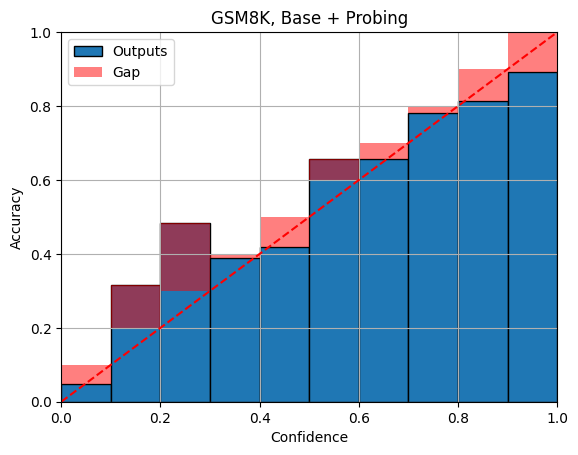

In [19]:
reliablity_diagram(new_df)